In [2]:
%matplotlib inline
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from classy import Class
from matplotlib.lines import Line2D
from smt.sampling_methods import LHS
from matplotlib.pyplot import cm
from uqpylab import sessions
from scipy.interpolate import interp1d
from scipy.spatial.distance import pdist
import statistics as st
import os, sys, warnings
from configparser import ConfigParser
from itertools import chain
import math
import seaborn as sns
from collections import defaultdict


def nested_dict(n, type):
    if n == 1:
        return defaultdict(type)
    else:
        return defaultdict(lambda: nested_dict(n-1, type))
    
data_kgb = nested_dict(5, list)



import os

# Where to save the figures

IMAGES_PATH = './images'
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="pdf", resolution=180):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    plt.savefig(path, format=fig_extension, dpi=resolution, bbox_inches='tight')

In [20]:
#path ="/home/ahmad/Desktop/cluster/Farbods_simulations/Kevolution/9000Boxsize-cs_e4-w09-Kevolution/output"
#path = "/home/ahmad/Desktop/cluster/Yggdrasil/2048^3_2Gp"


# # mid range
# path = "/home/ahmad/Desktop/cluster/Farbods_simulations/Kevolution/1280Boxsize-cs_e7-w09-Kevolution/output"
# data = np.loadtxt(path+'/kess_pk_cs_e7_w09_mid030_delta.dat')


# ## large range
path = "/home/ahmad/Desktop/cluster/Farbods_simulations/Kevolution/9000Boxsize-cs_e7-w09-Kevolution/output"
data = np.loadtxt(path+'/kess_pk_cs_e7_w09_large000_delta.dat')

## large range
# path = "/home/ahmad/Desktop/cluster/Spectra_gevoution_kevolution/kevolution_boxsize_4032_ngrid_4608_w_0m9_cs2_em4_05062020/output"
# data = np.loadtxt(path+'/kess_cs2e4_4032box_4608_pk014_delta.dat')

# path = "/home/ahmad/Desktop/cluster/Spectra_gevoution_kevolution/gevolution_boxsize_4032_ngrid_4608_lcdm_05062020/output"
# data = np.loadtxt(path+'/lcdm_pk016_delta.dat')

# # Hubble size
# path = "/home/ahmad/Desktop/cluster/HubbleSize/kev_cs2_e7_90000/output"
# data = np.loadtxt(path+'/kess_pk_cs_e7_w09_Hubble000_delta.dat')

# ## fluid 9000
# path = "/home/ahmad/Desktop/cluster/HubbleSize/fld_cs2_e7_90000/output"
# data = np.loadtxt(path+'/fld_cs7_w09_pk_Hubble_030_delta.dat')

kk_sim = data[:, 0]
pk = data[:, 1]

norm = (2 * (np.pi) ** 2) / ((kk_sim) ** 3)
pk_sim = norm * pk

In [21]:
z = [100]

def a(x):
    return 1/(1+x)

#kk = np.logspace(-3.2, np.log10(1), 1000)  # k in h/Mpc
kk= kk_sim

Pk_kgb = [[] for j in range(len(z))]
Pk_kess = [[] for j in range(len(z))]
Pk_LCDM = [[] for j in range(len(z))]



kgb_settings = {
    "Omega_smg": -1,
    "Omega_Lambda": 0,
    "Omega_fld": 0,
    "h": 0.67556,
    "omega_b": 0.022032,
    "omega_cdm":  0.12038,
    "A_s":  2.215e-9,
    "n_s": 0.9619,
    "z_max_pk": 100,
    "tau_reio": 0.05430842,
    "gravity_model": 'propto_omega',
    #"non linear": "Halofit",
    "parameters_smg": f"3e+06, 0, 0, 0, 1",
    "expansion_model": "w0wa",
    "expansion_smg": f"0.687862,-0.9,0",
    "extra metric transfer functions": "yes",
    "output": "dTk,vTk,mPk",
    "P_k_max_1/Mpc": 130,
}

kess_settings = kgb_settings.copy()
kess_settings["parameters_smg"] = f"3e+03, 0, 0, 0, 1"

LCDM_settings ={
        "Omega_scf": 0,
        #"Omega_Lambda": 0,
        "cs2_fld": 1e-07,
        "w0_fld": -0.9,
        "h": 0.67556,
        "omega_b": 0.022032,
        "omega_cdm":  0.12038,
        "Omega_fld": 0.687862,
        "A_s": 2.215e-9,
        "n_s": 0.9619,
        "z_max_pk": 100,
        "tau_reio": 0.05430842,
        "N_ur":3.046,
#         "N_ur": 1.0196,
#         "N_ncdm":2,
#         "m_ncdm": f"0.00868907, 0.05",
        "output": "mTk,mPk",
        "use_ppf":"no",
        "gauge":"Newtonian",
        "non linear":"Halofit",
        "P_k_max_1/Mpc": 192,
    }

# storying alpha_K_hat, alpha_B_hat, and w0
expansion_smg = kgb_settings["expansion_smg"].split(",")
parameters_smg = kgb_settings["parameters_smg"].split(",")

w0 = float(expansion_smg[1])
alpha_K_hat = float(parameters_smg[0])
alpha_B_hat = float(parameters_smg[1])
gravity_model= kgb_settings["gravity_model"]
#################################33###

M_kgb = Class()
M_kess = Class()
M_LCDM = Class()

M_kgb.set(kgb_settings)
M_kess.set(kess_settings)
M_LCDM.set(LCDM_settings)

M_kgb.compute()
M_kess.compute()
M_LCDM.compute()

k_pivot = 0.05
h = M_kgb.h()

As = kgb_settings["A_s"]
ns = kgb_settings["n_s"]


backgrounds = M_kgb.get_background()

rho_b = interp1d(backgrounds["z"], backgrounds["(.)rho_b"], kind="cubic")
rho_cdm = interp1d(backgrounds["z"], backgrounds["(.)rho_cdm"], kind="cubic")
rho_g = interp1d(backgrounds["z"], backgrounds["(.)rho_g"], kind="cubic")
rho_ur = interp1d(backgrounds["z"], backgrounds["(.)rho_ur"], kind="cubic")
rho_tot = interp1d(backgrounds["z"], backgrounds["(.)rho_tot"], kind="cubic")
rho_crit = interp1d(backgrounds["z"], backgrounds["(.)rho_crit"], kind="cubic")

H = interp1d(backgrounds["z"], backgrounds["H [1/Mpc]"], kind="cubic")
H_prime = interp1d(backgrounds["z"], backgrounds["H_prime"], kind="cubic")


rho_smg = interp1d(backgrounds["z"], backgrounds["(.)rho_smg"], kind="cubic")
rho_smg_prime = interp1d(backgrounds["z"], backgrounds["(.)rho_smg_prime"], kind="cubic")
p_smg = interp1d(backgrounds["z"], backgrounds["(.)p_smg"], kind="cubic")
alpha_K = interp1d(backgrounds["z"], backgrounds["kineticity_smg"], kind="cubic")
alpha_B = interp1d(backgrounds["z"], backgrounds["braiding_smg"], kind="cubic")


H0_squared = H(0) ** 2

Mpl2 = 1 / (3.0 * H0_squared)


Delta_rhoDE_kgb = [None] * len(z)

for zind, zi in enumerate(z):

    Hconf = a(zi) * H(zi)
    Hconf_prime = (a(zi) ** 2) * (H(zi) ** 2) + a(zi) * H_prime(zi)

    rho_m = rho_b(zi) + rho_cdm(zi)
    
    rho_excde = rho_tot(zi) - rho_smg(zi)

    rho_sum = rho_cdm(zi) + rho_b(zi) + rho_g(zi) + rho_ur(zi)
    
    Transfers_newt = M_LCDM.get_transfer(zi)

    #############
    delta_cdm_newt = interp1d(
         Transfers_newt["k (h/Mpc)"],  Transfers_newt["d_cdm"], kind="cubic"
    )
    
    delta_b_newt = interp1d(
         Transfers_newt["k (h/Mpc)"],  Transfers_newt["d_b"], kind="cubic"
    )
    
   
    
    delta_tot_newt = interp1d(
        Transfers_newt["k (h/Mpc)"], Transfers_newt["d_tot"], kind="cubic"
    )

    #######################################################################################################
    #                                                 synchronous

    Transfers_syn = M_kgb.get_transfer(zi)

    #############
    delta_b_syn = interp1d(
        Transfers_syn["k (h/Mpc)"], Transfers_syn["d_b"], kind="cubic"
    )
    theta_b_syn = interp1d(
        Transfers_syn["k (h/Mpc)"], Transfers_syn["t_b"], kind="cubic"
    )
    #############
    #                         theta_cdm is zero in synchronous gauge
    delta_cdm_syn = interp1d(
        Transfers_syn["k (h/Mpc)"], Transfers_syn["d_cdm"], kind="cubic"
    )
    #############
    delta_g_syn = interp1d(
        Transfers_syn["k (h/Mpc)"], Transfers_syn["d_g"], kind="cubic"
    )
    theta_g_syn = interp1d(
        Transfers_syn["k (h/Mpc)"], Transfers_syn["t_g"], kind="cubic"
    )
    #############
    delta_ur_syn = interp1d(
        Transfers_syn["k (h/Mpc)"], Transfers_syn["d_ur"], kind="cubic"
    )
    theta_ur_syn = interp1d(
        Transfers_syn["k (h/Mpc)"], Transfers_syn["t_ur"], kind="cubic"
    )
    #############

    delta_tot_syn = interp1d(
        Transfers_syn["k (h/Mpc)"], Transfers_syn["d_tot"], kind="cubic"
    )

    theta_tot_syn = interp1d(
        Transfers_syn["k (h/Mpc)"], Transfers_syn["t_tot"], kind="cubic"
    )

    phi_syn = interp1d(Transfers_syn["k (h/Mpc)"], Transfers_syn["phi"], kind="cubic")
    phi_prime_syn = interp1d(
        Transfers_syn["k (h/Mpc)"], Transfers_syn["phi_prime"], kind="cubic"
    )
    psi_syn = interp1d(Transfers_syn["k (h/Mpc)"], Transfers_syn["psi"], kind="cubic")

    vx_smg = interp1d(Transfers_syn["k (h/Mpc)"], Transfers_syn["vx_smg"], kind="cubic")
    vx_prime_smg = interp1d(
        Transfers_syn["k (h/Mpc)"], Transfers_syn["vx_prime_smg"], kind="cubic"
    )
    eta = interp1d(Transfers_syn["k (h/Mpc)"], Transfers_syn["eta"], kind="cubic")
    eta_prime = interp1d(
        Transfers_syn["k (h/Mpc)"], Transfers_syn["eta_prime"], kind="cubic"
    )

    h_met = interp1d(Transfers_syn["k (h/Mpc)"], Transfers_syn["h"], kind="cubic")
    h_prime_met = interp1d(
        Transfers_syn["k (h/Mpc)"], Transfers_syn["h_prime"], kind="cubic"
    )
    
    tmp_kgb = []
    tmp_kess = []
    tmp_LCDM = []

    for k in kk:
        tmp_kgb.append(M_kgb.pk(k * h, zi) * h**3)
        tmp_kess.append(M_kess.pk(k * h, zi) * h**3)
        #tmp_LCDM.append(M_LCDM.pk(k * h, zi) * h**3)
        
        delta_cdm_b_newt = (rho_cdm(zi)*delta_cdm_newt(k)+rho_b(zi)*delta_b_newt(k))/rho_m
        
        tmp_LCDM.append((2* (np.pi**2)/((k)**3) * As * (k*h/ k_pivot) ** (ns - 1.0))*delta_cdm_b_newt**2)
        
        
    Pk_kgb[zind] = tmp_kgb
    Pk_kess[zind] = tmp_kess
    Pk_LCDM[zind] = tmp_LCDM

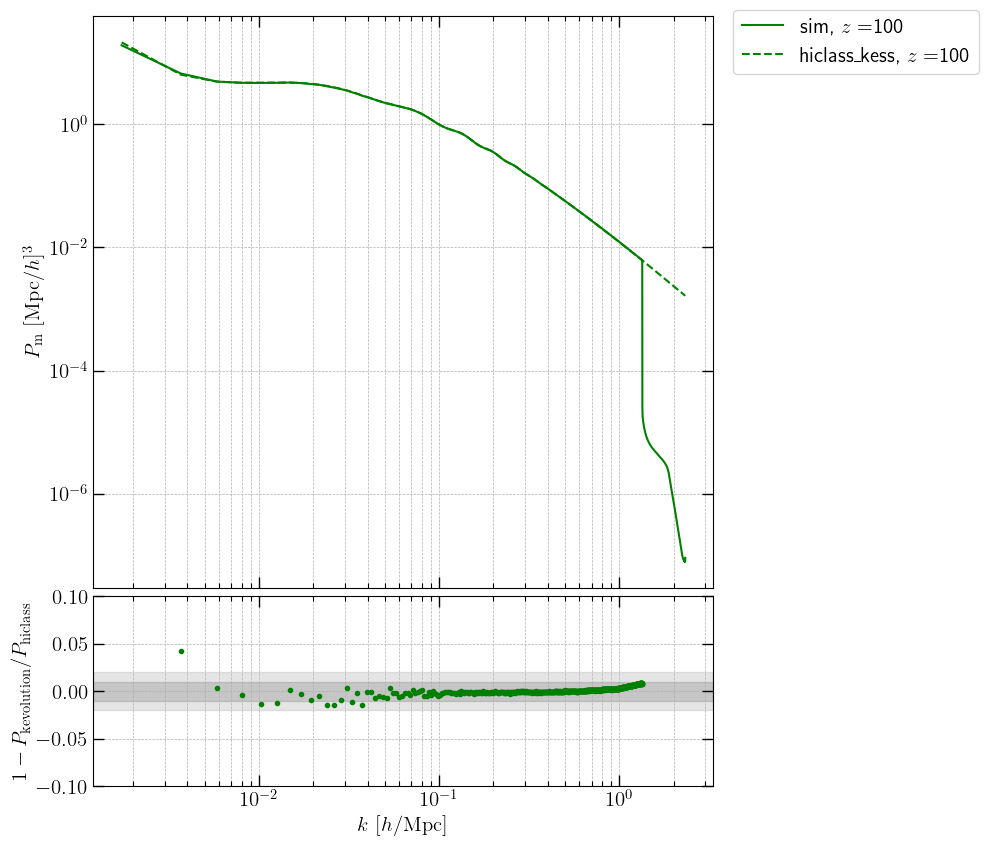

In [22]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(
    2, 1, gridspec_kw={"height_ratios": [3, 1]}, figsize=(8, 10), sharex=True
)
plt.subplots_adjust(hspace=0.022, wspace=0.23)


c = sns.color_palette("viridis", len(z)).as_hex()

plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 18}


zind = -1


############################################################################
#                                          hiclass

ax[0].plot(
    kk_sim,
    pk_sim,
    '-',
    c="green",
    label="sim, $z=$" + str(z[zind]),
    markersize=2,
)


ax[0].plot(
    kk_sim,
    Pk_LCDM[0],
    "--",
    c="green",
    label="hiclass_kess, $z=$" + str(z[zind]),
    markersize=2,
)


############################################################################
#                                        KGB-evolution

# ax[0].errorbar(
#     kk_kgb,
#     norm_nyq*pk_matter_kgb[-1],yerr=sigma_pk_matter_kgb[-1],fmt='-', markersize=4, capsize=3,
#     label="KGB-evolution, $z=$" + str(z[zind]),

# )

# ax[0].plot(
#     kk_kgb,
#     norm_nyq*pk_matter_kgb[zind],'o', markersize=3,
#     label="KGB-evolution, $z=$" + str(z[zind]),

# )

# ax[0].errorbar(
#     kk_sim,
#     norm_nyq * pk_matter_kgb[zind],
#     yerr=norm_nyq*error_pk_matter_kgb[zind],
#     fmt="o",
#     elinewidth=1,
#     ms=2,
# )
############################################################################
#                                       Rel-Diff


#     ax[0].plot(
#         kk,
#         Pk_LCDM[zind],"o",
#         c=c[zind],
#         label="LCDMs, $z=$" + str(z[zind]),
#         markersize=1
#     )

ax[1].plot(
    kk,
    1-np.array(Pk_LCDM[0])/pk_sim,"o",
    c='green',
    label="hiclass, $z=$" + str(z[zind]),
    markersize=3
)

# ax[1].errorbar(
#     kk_sim,
#     1 - np.array(norm_nyq * pk_matter_kgb[zind]) / Pk_kgb[0],
#     yerr=norm_nyq *np.array(error_pk_matter_kgb[zind]) / Pk_kgb[0],
#     fmt="o",
#     elinewidth=1,
#     ms=2,
# )

ax[1].axhspan(-0.01, 0.01, color="gray", alpha=0.3, label="1% region")
ax[1].axhspan(-0.02, 0.02, color="gray", alpha=0.2, label="2% region")

ax[1].set_ylim(-0.1,0.1)
#ax[1].set_xlim(5.8e-03,5)
#ax[1].set_yscale("symlog", linthresh=0.02)

formatter = ticker.ScalarFormatter()
formatter.set_scientific(False)
ax[1].yaxis.set_major_formatter(formatter)


for i in range(2):
    ax[i].set_xscale("log")

    # plt.xlim(5.0e-5, 0.01)
    # plt.ylim(1.e-17,3.e-9)
    ax[i].grid(which="both", axis="both", linestyle="--", linewidth=0.5)

    ax[i].tick_params("both", length=8, width=1, which="major")
    ax[i].tick_params("both", length=3.5, width=0.8, which="minor")
    ax[i].tick_params(direction="in", which="major", labelsize=15)
    ax[i].tick_params(direction="in", which="minor")
    ax[i].yaxis.set_ticks_position("both")
    ax[i].xaxis.set_ticks_position("both")


ax[0].set_yscale("log")
ax[0].set_ylabel(r"$P_\mathrm{m}~ [\mathrm{Mpc}/h]^3$", fontsize=15)
ax[1].set_ylabel(r"$1-P_\mathrm{kevolution}/P_\mathrm{hiclass}$", fontsize=15)
ax[1].set_xlabel("$k~ [h/\mathrm{Mpc}]$", fontsize=15)


ax[0].legend(
    fontsize=15,  # Font size
    loc="upper center",  # Place legend above the plot
    bbox_to_anchor=(1.23, 1.03),  # Position outside plot area (x, y relative to axes)
    ncol=1,  # Number of columns
)



plt.rc("text", usetex=True)
font = {"family": "normal", "weight": "bold", "size": 15}